In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import GoogLeNet_Weights
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)

data_dir = "./asl_alphabet_train/asl_alphabet_train"
batch_size = 32
num_epochs = 10
num_classes = 29
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [3]:
# ========== Load and partition the dataset ==========
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
total_len = len(full_dataset)
val_len = int(total_len * 0.3)
test_len = int(total_len * 0.3)
train_len = total_len - val_len - test_len

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_len, val_len, test_len])
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# ========== Initialize GoogLeNet ==========
model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4,weight_decay=1e-4)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',       
    factor=0.5,       
    patience=2,      
    verbose=True
)

D:\Users\Manson\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(
D:\Users\Manson\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# ===== Training function =====
def train_model(model, train_loader, val_loader, epochs, scheduler=None):
    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):

        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader,
                                  desc=f"Epoch {epoch+1}/{epochs} Train",
                                  leave=False, dynamic_ncols=True):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        

        # Validation
        model.eval()
        val_running_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        


        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc.item())
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Val Acc={val_acc:.4f}")
        
        if scheduler is not None:
            scheduler.step(val_loss)


        if val_acc > best_acc:
            best_acc = val_acc
            os.makedirs("models", exist_ok=True)
            torch.save(model.state_dict(), "models/best_googlenet.pth")

    return history


In [6]:
# ===== Drawing functions =====
import matplotlib.pyplot as plt

def plot_history(history):
    epochs_range = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 5))

    # Loss 曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history["train_loss"], label='Train Loss')
    plt.plot(epochs_range, history["val_loss"], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history["train_acc"], label='Train Accuracy')
    plt.plot(epochs_range, history["val_acc"], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/10 Train:   0%|                                                                       | 0/1088 [00:00<…

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.3162 Train Acc=0.9536 | Val Loss=0.0043 Val Acc=0.9997


Epoch 2/10 Train:   0%|                                                                       | 0/1088 [00:00<…

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.0071 Train Acc=0.9994 | Val Loss=0.0019 Val Acc=0.9995


Epoch 3/10 Train:   0%|                                                                       | 0/1088 [00:00<…

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.0093 Train Acc=0.9981 | Val Loss=0.0006 Val Acc=0.9999


Epoch 4/10 Train:   0%|                                                                       | 0/1088 [00:00<…

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.0038 Train Acc=0.9992 | Val Loss=0.0013 Val Acc=0.9997


Epoch 5/10 Train:   0%|                                                                       | 0/1088 [00:00<…

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.0083 Train Acc=0.9980 | Val Loss=0.0010 Val Acc=0.9998


Epoch 6/10 Train:   0%|                                                                       | 0/1088 [00:00<…

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.0009 Train Acc=0.9999 | Val Loss=0.0010 Val Acc=0.9997


Epoch 7/10 Train:   0%|                                                                       | 0/1088 [00:00<…

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.0004 Train Acc=1.0000 | Val Loss=0.0003 Val Acc=0.9999


Epoch 8/10 Train:   0%|                                                                       | 0/1088 [00:00<…

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.0002 Train Acc=1.0000 | Val Loss=0.0007 Val Acc=0.9998


Epoch 9/10 Train:   0%|                                                                       | 0/1088 [00:00<…

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.0015 Train Acc=0.9997 | Val Loss=0.0002 Val Acc=0.9999


Epoch 10/10 Train:   0%|                                                                      | 0/1088 [00:00<…

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.0011 Train Acc=0.9998 | Val Loss=0.0001 Val Acc=1.0000


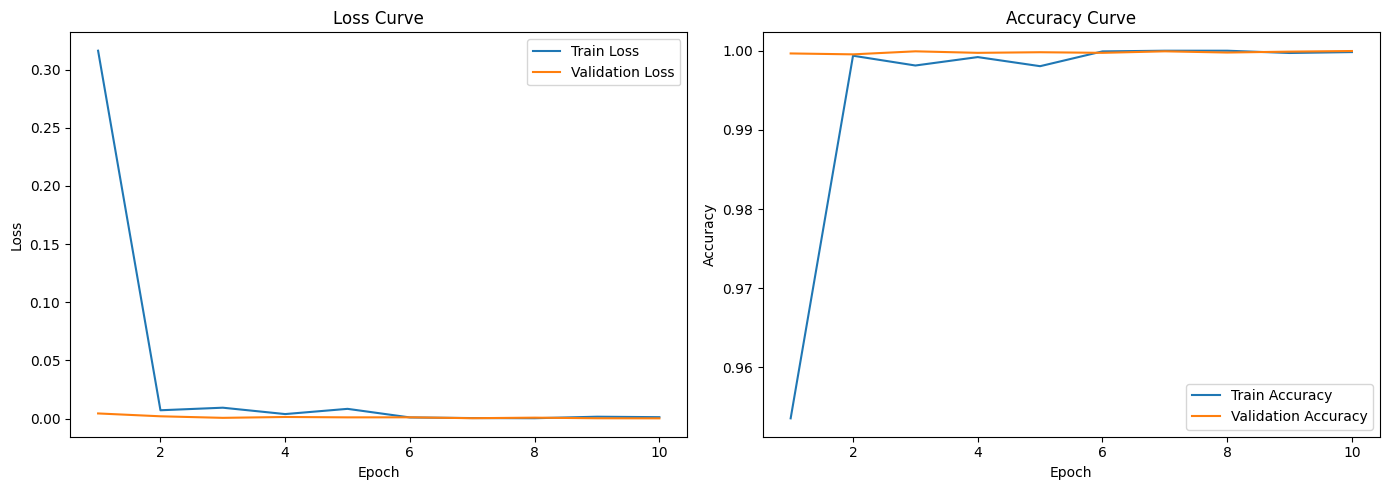

In [7]:
# ========== Train and visualize ==========
history = train_model(
    model,
    train_loader,
    val_loader,
    epochs=num_epochs,
    scheduler=scheduler
)

plot_history(history)

In [7]:
# ========== Model Evaluation ==========
model = models.googlenet(weights=None, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
model.load_state_dict(torch.load("models/best_googlenet.pth", map_location=device))
model.eval()

D:\Users\Manson\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
C:\Users\Manson\AppData\Local\Temp\ipykernel_20836\3344449832.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unl

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [9]:
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ========== Output evaluation indicators ==========
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
acc = accuracy_score(all_labels, all_preds)

print(f"\nPrecision = {precision:.4f}")
print(f"Recall    = {recall:.4f}")
print(f"F1        = {f1:.4f}")
print(f"Accuracy  = {acc:.2%}")



Precision = 0.9888
Recall    = 0.9882
F1        = 0.9882
Accuracy  = 98.82%


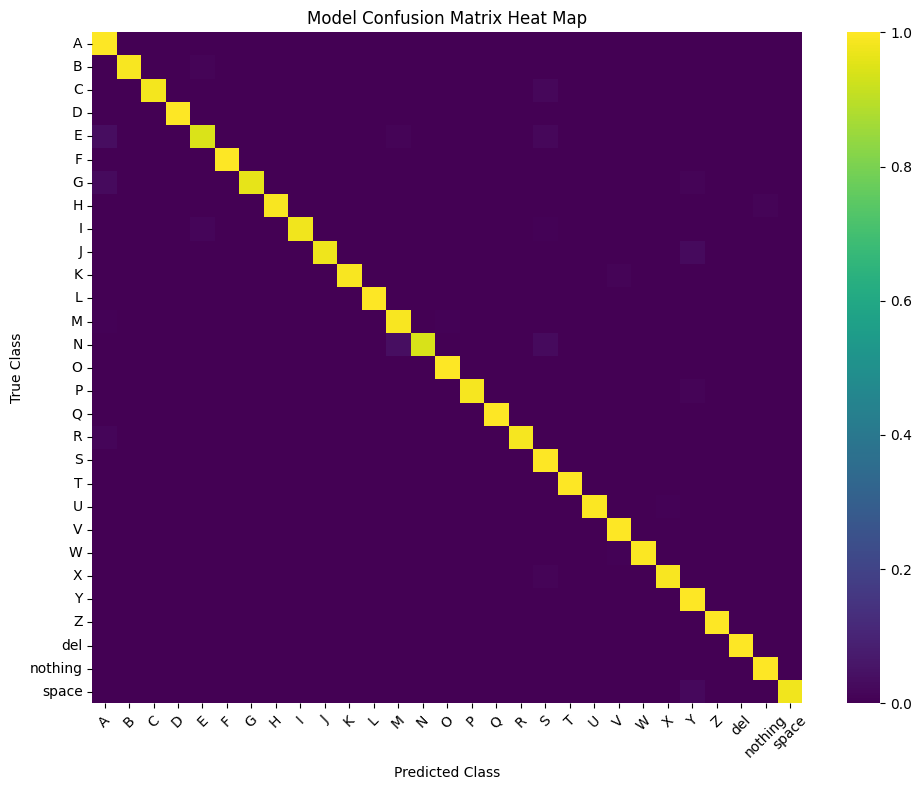

In [11]:
# ========== Confusion Matrix Visualization ==========
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, cmap="viridis", cbar=True,
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title("Model Confusion Matrix Heat Map")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# ====== Configuration ======
test_dir = "./archive"
batch_size = 32

In [11]:
# ====== Define preprocessing (same as training) ======
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# ====== Load test dataset ======
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ====== Load GoogLeNet model ======
model = models.googlenet(weights=None, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
model.load_state_dict(torch.load("models/best_googlenet.pth", map_location=device))
model.eval()

D:\Users\Manson\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
C:\Users\Manson\AppData\Local\Temp\ipykernel_10632\37794985.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
# ====== Run inference ======
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ========== Output evaluation indicators ==========
precision = precision_score(all_labels, all_preds, average='macro')
recall    = recall_score(all_labels, all_preds, average='macro')
f1        = f1_score(all_labels, all_preds, average='macro')
acc       = accuracy_score(all_labels, all_preds)

print("\nEvaluation Metrics on Supplementary Dataset:")
print(f"Precision = {precision:.4f}")
print(f"Recall    = {recall:.4f}") 
print(f"F1 Score  = {f1:.4f}")
print(f"Accuracy  = {acc:.2%}")


Evaluation Metrics on Supplementary Dataset:
Precision = 0.7535
Recall    = 0.6782
F1 Score  = 0.6569
Accuracy  = 67.82%


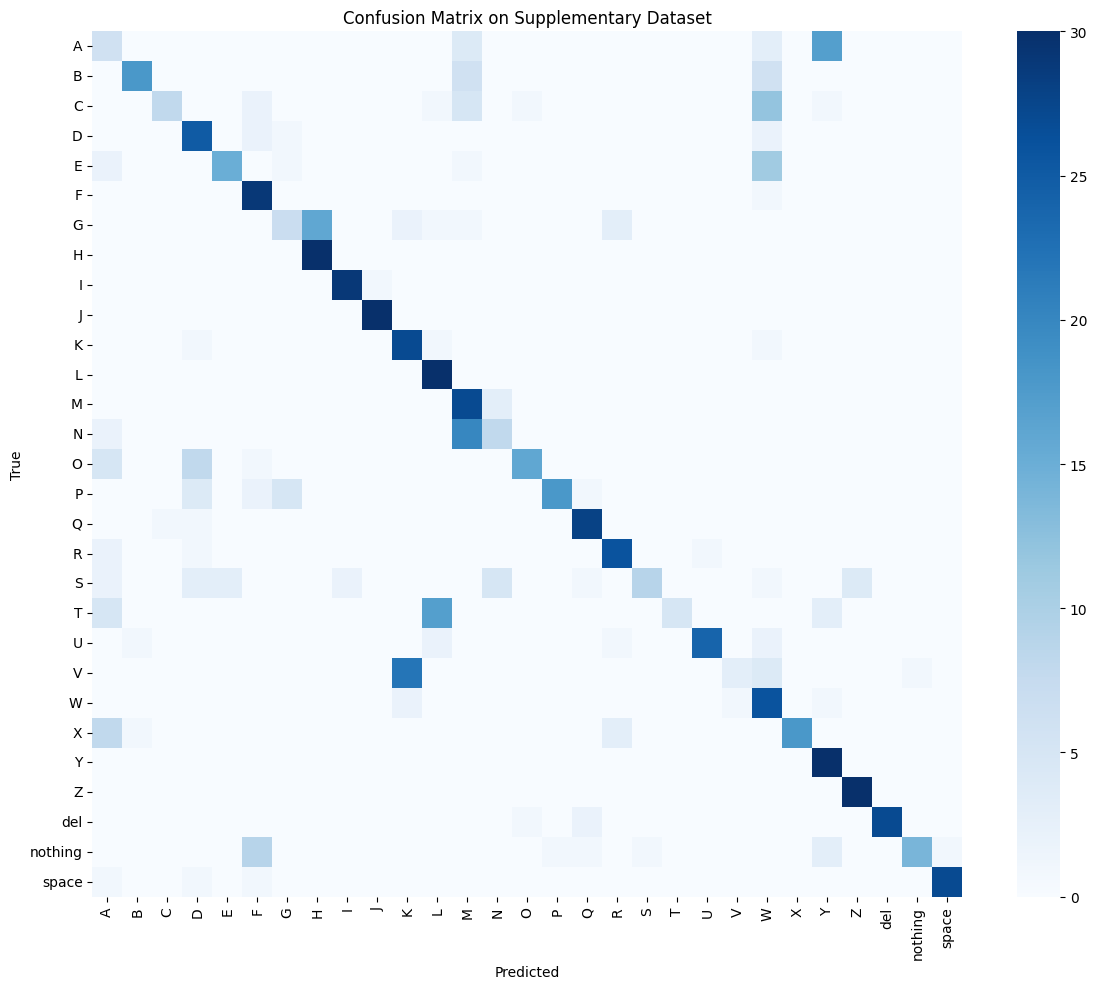

In [13]:
# ====== Confusion Matrix ======
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("Confusion Matrix on Supplementary Dataset")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()